<h1> Structured data prediction using Cloud ML Engine </h1>

This notebook illustrates:
<ol>
<li> Exploring a BigQuery dataset using Datalab
<li> Creating datasets for Machine Learning using Dataflow
<li> Creating a model using the high-level Estimator API 
<li> Training on Cloud ML Engine
<li> Deploying model
<li> Predicting with model
</ol>

In [1]:
# change these to try this notebook out
BUCKET = 'cloud-training-demos-ml'
PROJECT = 'cloud-training-demos'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

Creating gs://cloud-training-demos-ml/...


<h2> Explore data </h2>

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that.

In [4]:
query="""
SELECT
  weight_pounds,
  is_male,
  mother_age,
  mother_race,
  plurality,
  gestation_weeks,
  mother_married,
  ever_born,
  cigarette_use,
  alcohol_use,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

In [5]:
import google.datalab.bigquery as bq
df = bq.Query(query + " LIMIT 100").execute().result().to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,mother_race,plurality,gestation_weeks,mother_married,ever_born,cigarette_use,alcohol_use,hashmonth
0,6.437498,True,25,2,1,39.0,True,3,None,False,-1525201076796226340
1,6.124442,True,33,1,1,38.0,True,1,None,False,6392072535155213407
2,6.876218,True,20,1,1,42.0,True,1,None,False,8904940584331855459
3,8.750147,True,21,1,1,39.0,False,1,None,False,6691862025345277042
4,8.187968,True,21,3,1,38.0,False,1,None,False,8387817883864991792


Let's write a query to find the unique values for each of the columns and the count of those values.

In [6]:
def get_distinct_values(column_name):
  sql = """
SELECT
  {0},
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY
  {0}
  """.format(column_name)
  return bq.Query(sql).execute().result().to_dataframe()

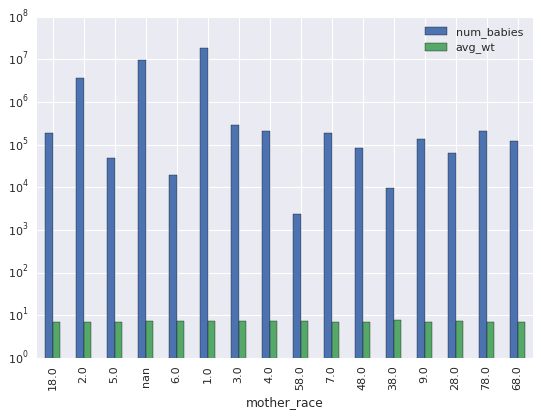

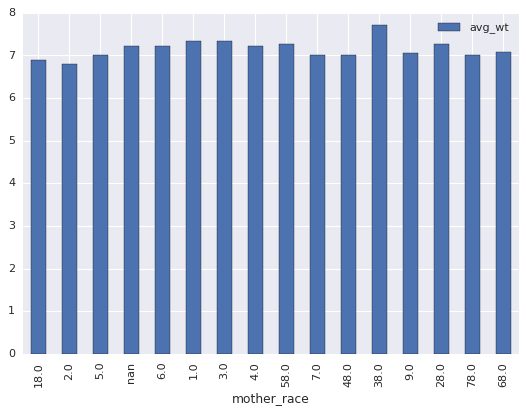

In [7]:
df = get_distinct_values('mother_race')
df.plot(x='mother_race', logy='num_babies', kind='bar');
df.plot(x='mother_race', y='avg_wt', kind='bar');

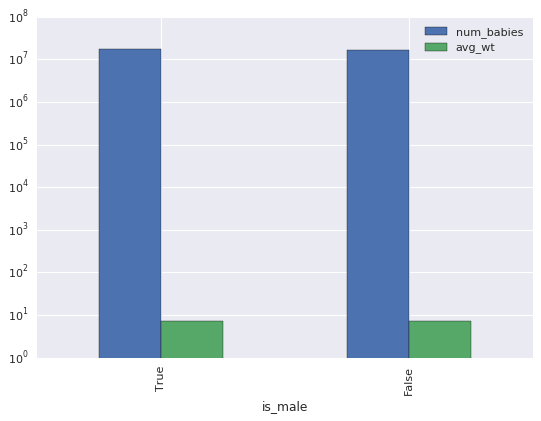

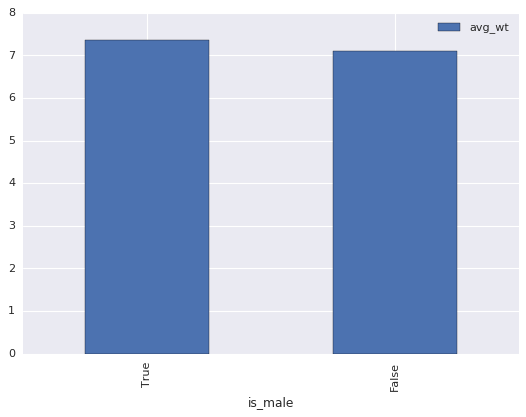

In [8]:
df = get_distinct_values('is_male')
df.plot(x='is_male', logy='num_babies', kind='bar');
df.plot(x='is_male', y='avg_wt', kind='bar');

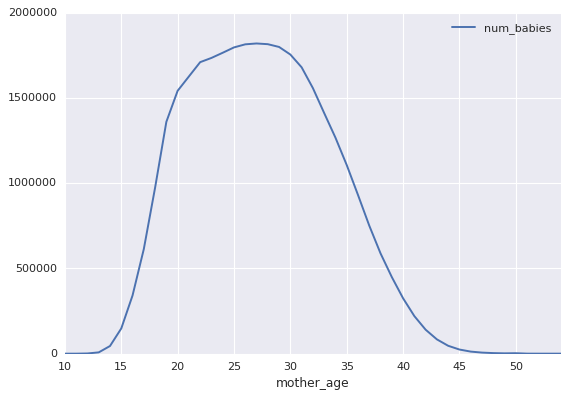

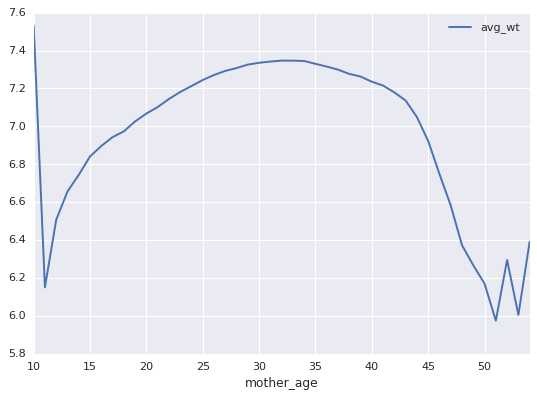

In [9]:
df = get_distinct_values('mother_age')
df = df.sort_values('mother_age')
df.plot(x='mother_age', y='num_babies');
df.plot(x='mother_age', y='avg_wt');

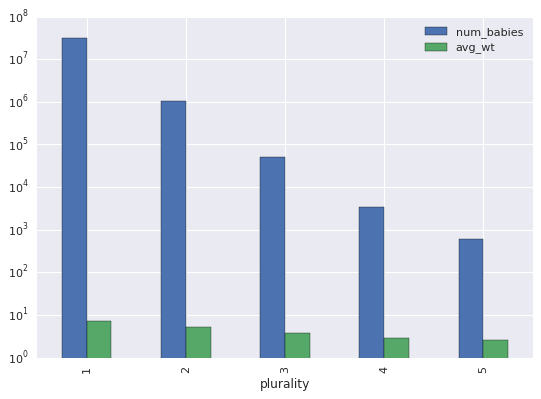

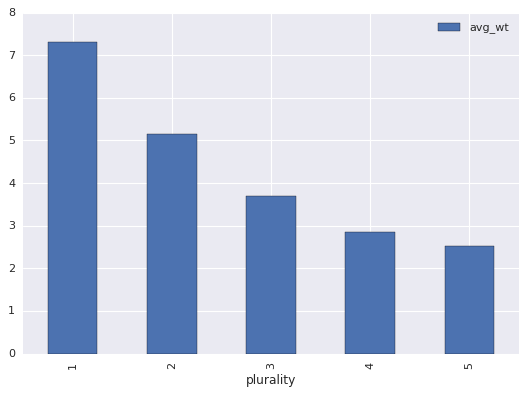

In [10]:
df = get_distinct_values('plurality')
df = df.sort_values('plurality')
df.plot(x='plurality', logy='num_babies', kind='bar');
df.plot(x='plurality', y='avg_wt', kind='bar');

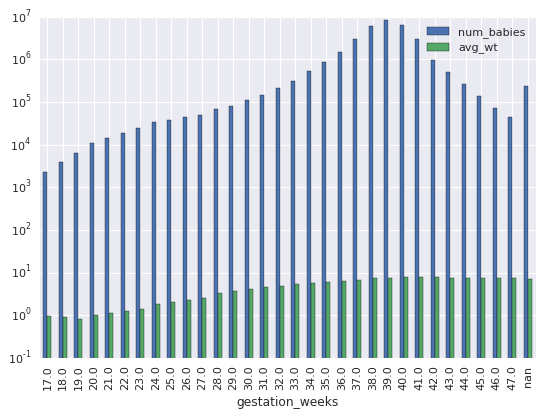

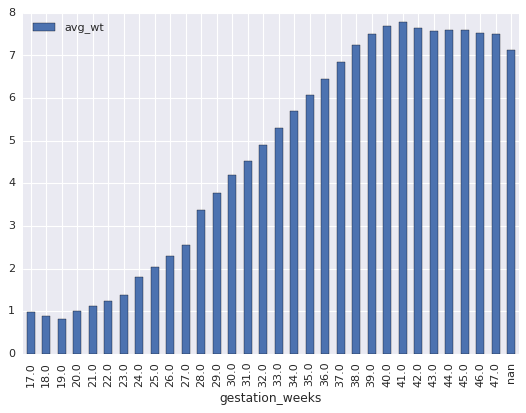

In [11]:
df = get_distinct_values('gestation_weeks')
df = df.sort_values('gestation_weeks')
df.plot(x='gestation_weeks', logy='num_babies', kind='bar');
df.plot(x='gestation_weeks', y='avg_wt', kind='bar');

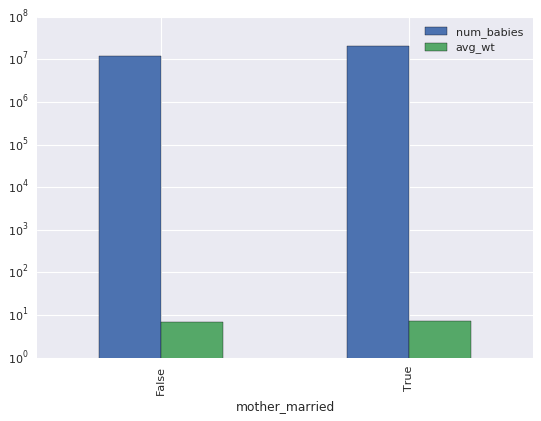

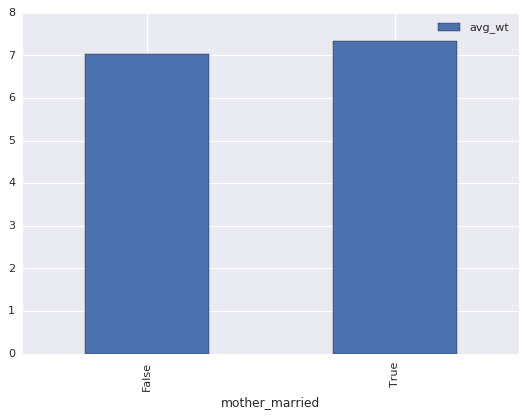

In [12]:
df = get_distinct_values('mother_married')
df.plot(x='mother_married', logy='num_babies', kind='bar');
df.plot(x='mother_married', y='avg_wt', kind='bar');

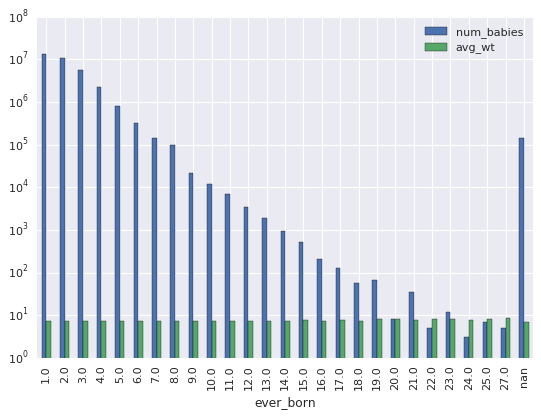

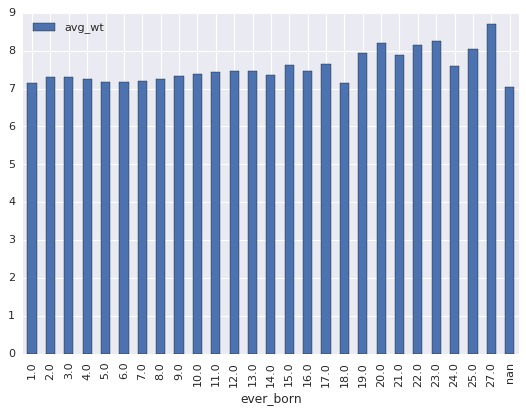

In [13]:
df = get_distinct_values('ever_born')
df = df.sort_values('ever_born')
df.plot(x='ever_born', logy='num_babies', kind='bar');
df.plot(x='ever_born', y='avg_wt', kind='bar');

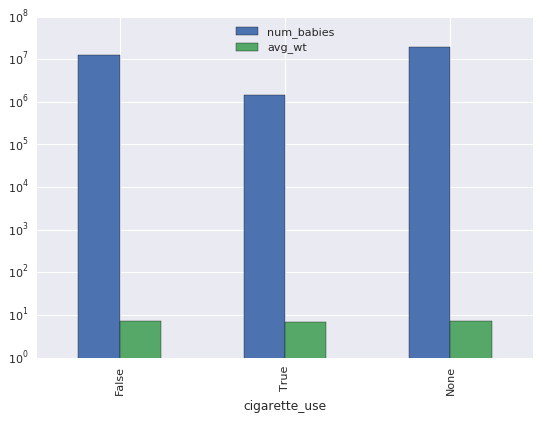

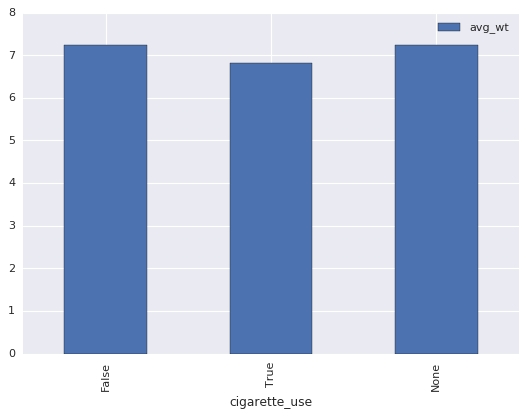

In [14]:
df = get_distinct_values('cigarette_use')
df.plot(x='cigarette_use', logy='num_babies', kind='bar');
df.plot(x='cigarette_use', y='avg_wt', kind='bar');

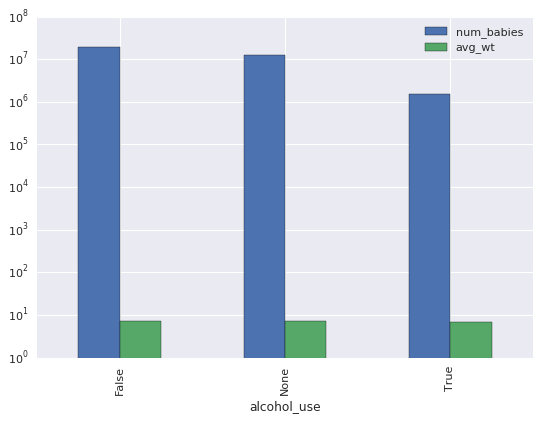

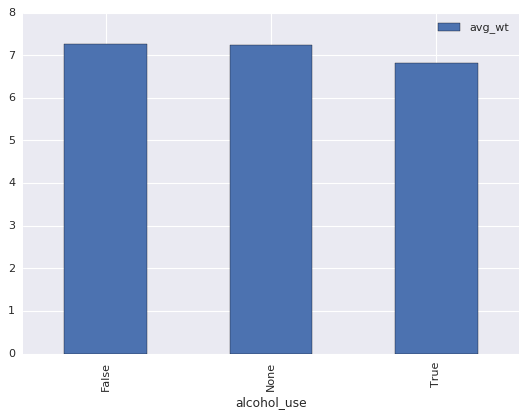

In [15]:
df = get_distinct_values('alcohol_use')
df.plot(x='alcohol_use', logy='num_babies', kind='bar');
df.plot(x='alcohol_use', y='avg_wt', kind='bar');

Other than the ever_born (the total number of babies born to this mother), the factors all seem to play a part in the baby's weight.  Male babies are heavier on average than female babies. The mother's age and race play a part (age much more than race -- teenage and middle-aged moms tend to have lower-weight babies).  Twins, triplets, etc. are lower weight than single births.  Preemies weigh in lower as do babies born to single moms. Moms who use alcohol or cigarettes have babies that weigh lower on average.
<p>
In the rest of this notebook, we will use machine learning to combine all of these factors to come up with a prediction of a baby's weight.

<h2> Create ML dataset using Dataflow </h2>
<p>
Let's use Cloud Dataflow to read in the BigQuery data and write it out as CSV files. 

Instead of using Beam/Dataflow, I had two other options:
<ol>
<li> Read from BigQuery directly using TensorFlow. However, using CSV files gives us the advantage of shuffling during read. This is important for distributed training because some workers might be slower than others, and shuffling the data helps prevent the same data from being assigned to the slow workers.
<li> Use the BigQuery console (http://bigquery.cloud.google.com) to run a Query and save the result as a CSV file. For larger datasets, you may have to select the option to "allow large results" and save the result into a CSV file on Google Cloud Storage. However, in this case, I want to do some preprocessing (on the "race" column). If I didn't need preprocessing, I could have used the web console. Also, I prefer to script it out rather than run queries on the user interface, so I am using Cloud Dataflow for the preprocessing.
</ol>

<p>
Note that after you launch this, the notebook will appear to be hung. Go to the GCP webconsole to the Dataflow section and monitor the running job. It took about <b>30 minutes</b> for me.

In [16]:
import apache_beam as beam
import datetime

def to_csv(rowdict):
    # pull columns from BQ and create a line
    import hashlib
    import copy
    CSV_COLUMNS = 'weight_pounds,is_male,mother_age,mother_race,plurality,gestation_weeks,mother_married,cigarette_use,alcohol_use'.split(',')
    # modify opaque numeric race code into human-readable data
    races = dict(zip([1,2,3,4,5,6,7,18,28,39,48],
                     ['White', 'Black', 'American Indian', 'Chinese', 
                      'Japanese', 'Hawaiian', 'Filipino',
                      'Asian Indian', 'Korean', 'Samaon', 'Vietnamese']))
    result = copy.deepcopy(rowdict)
    if 'mother_race' in rowdict and rowdict['mother_race'] in races:
      result['mother_race'] = races[rowdict['mother_race']]
    else:
      result['mother_race'] = 'Unknown'
    
    data = ','.join([str(result[k]) if k in result else 'None' for k in CSV_COLUMNS])
    key = hashlib.sha224(data).hexdigest()  # hash the columns to form a key
    return str('{},{}'.format(data, key))
  
def preprocess(in_test_mode):
  job_name = 'preprocess-babyweight-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
    
  if in_test_mode:
    print 'Launching local job ... hang on'
    OUTPUT_DIR = './preproc'
  else:
    print 'Launching Dataflow job {} ... hang on'.format(job_name)
    OUTPUT_DIR = 'gs://{0}/babyweight/preproc/'.format(BUCKET)
    
  options = {
    'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
    'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
    'job_name': job_name,
    'project': PROJECT,
    'teardown_policy': 'TEARDOWN_ALWAYS',
    'no_save_main_session': True
  }
  opts = beam.pipeline.PipelineOptions(flags=[], **options)
  if in_test_mode:
    RUNNER = 'DirectRunner'
  else:
    RUNNER = 'DataflowRunner'
  p = beam.Pipeline(RUNNER, options=opts)
  query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  mother_race,
  plurality,
  gestation_weeks,
  mother_married,
  ever_born,
  cigarette_use,
  alcohol_use,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
AND weight_pounds > 0
AND mother_age > 0
AND plurality > 0
AND gestation_weeks > 0
AND month > 0
    """
  
  if in_test_mode:
    query = query + ' LIMIT 100' 
  
  for step in ['train', 'eval']:
    if step == 'train':
      selquery = 'SELECT * FROM ({}) WHERE MOD(hashmonth,4) < 3'.format(query)
    else:
      selquery = 'SELECT * FROM ({}) WHERE MOD(hashmonth,4) = 3'.format(query)

    (p 
     | '{}_read'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query=selquery, use_standard_sql=True))
     | '{}_csv'.format(step) >> beam.Map(to_csv)
     | '{}_out'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, '{}.csv'.format(step))))
    )
 
  job = p.run()
  
preprocess(in_test_mode=False)

Launching Dataflow job preprocess-babyweight-features-170412-063852 ... hang on


/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:136: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)


<img src="dataflow.png" width="500"/>

In [17]:
%bash
gsutil ls gs://${BUCKET}/babyweight/preproc/*-00000*

gs://cloud-training-demos-ml/babyweight/preproc/eval.csv-00000-of-00016
gs://cloud-training-demos-ml/babyweight/preproc/train.csv-00000-of-00040


<h2> Create TensorFlow model using TensorFlow's Estimator API </h2>
<p>
First, write an input_fn to read the data.

In [18]:
import shutil
import tensorflow as tf
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics

In [19]:
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,mother_race,plurality,gestation_weeks,mother_married,cigarette_use,alcohol_use,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN = 'key'
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], [0.0], ['null'], ['null'], ['null'], ['nokey']]
TRAIN_STEPS = 1000

def read_dataset(prefix, pattern, batch_size=512):
  # use prefix to create filename
  filename = 'gs://{}/babyweight/preproc/{}*{}*'.format(BUCKET, prefix, pattern)
  if prefix == 'train':
    mode = tf.contrib.learn.ModeKeys.TRAIN
  else:
    mode = tf.contrib.learn.ModeKeys.EVAL
    
  # the actual input function passed to TensorFlow
  def _input_fn():
    # could be a path to one file or a file pattern.
    input_file_names = tf.train.match_filenames_once(filename)
    filename_queue = tf.train.string_input_producer(
        input_file_names, shuffle=True)
 
    # read CSV
    reader = tf.TextLineReader()
    _, value = reader.read_up_to(filename_queue, num_records=batch_size)
    value_column = tf.expand_dims(value, -1)
    columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
    features = dict(zip(CSV_COLUMNS, columns))
    features.pop(KEY_COLUMN)
    label = features.pop(LABEL_COLUMN)
    return features, label
  
  return _input_fn

Next, define the feature columns

In [20]:
def get_wide_deep():
  # define column types
  races = ['White', 'Black', 'American Indian', 'Chinese', 
           'Japanese', 'Hawaiian', 'Filipino', 'Unknown',
           'Asian Indian', 'Korean', 'Samaon', 'Vietnamese']
  is_male,mother_age,mother_race,plurality,gestation_weeks,mother_married,cigarette_use,alcohol_use = \
   [ \
    tflayers.sparse_column_with_keys('is_male', keys=['True', 'False']),
    tflayers.real_valued_column('mother_age'),
    tflayers.sparse_column_with_keys('mother_race', keys=races),
    tflayers.real_valued_column('plurality'),
    tflayers.real_valued_column('gestation_weeks'),
    tflayers.sparse_column_with_keys('mother_married', keys=['True', 'False']),
    tflayers.sparse_column_with_keys('cigarette_use', keys=['True', 'False', 'None']),
    tflayers.sparse_column_with_keys('alcohol_use', keys=['True', 'False', 'None'])
    ]

  # which columns are wide (sparse, linear relationship to output) and which are deep (complex relationship to output?)  
  wide = [is_male, mother_race, plurality, mother_married, cigarette_use, alcohol_use]
  deep = [\
                mother_age,
                gestation_weeks,
                tflayers.embedding_column(mother_race, 3)
               ]
  return wide, deep

To predict with the TensorFlow model, we also need a serving input function. We will want all the inputs from our user.

In [21]:
def serving_input_fn():
    feature_placeholders = {
      'is_male': tf.placeholder(tf.string, [None]),
      'mother_age': tf.placeholder(tf.float32, [None]),
      'mother_race': tf.placeholder(tf.string, [None]),
      'plurality': tf.placeholder(tf.float32, [None]),
      'gestation_weeks': tf.placeholder(tf.float32, [None]),
      'mother_married': tf.placeholder(tf.string, [None]),
      'cigarette_use': tf.placeholder(tf.string, [None]),
      'alcohol_use': tf.placeholder(tf.string, [None])
    }
    features = {
      key: tf.expand_dims(tensor, -1)
      for key, tensor in feature_placeholders.items()
    }
    return tflearn.utils.input_fn_utils.InputFnOps(
      features,
      None,
      feature_placeholders)

Finally, train!

In [22]:
from tensorflow.contrib.learn.python.learn.utils import saved_model_export_utils

pattern = "00001-of-"  # process only one of the shards, for testing purposes

def experiment_fn(output_dir):
    wide, deep = get_wide_deep()
    return tflearn.Experiment(
        tflearn.DNNLinearCombinedRegressor(model_dir=output_dir,
                                           linear_feature_columns=wide,
                                           dnn_feature_columns=deep,
                                           dnn_hidden_units=[64, 32]),
        train_input_fn=read_dataset('train', pattern),
        eval_input_fn=read_dataset('eval', pattern),
        eval_metrics={
            'rmse': tflearn.MetricSpec(
                metric_fn=metrics.streaming_root_mean_squared_error
            )
        },
        export_strategies=[saved_model_export_utils.make_export_strategy(
            serving_input_fn,
            default_output_alternative_key=None,
            exports_to_keep=1
        )],
        train_steps=TRAIN_STEPS
    )

shutil.rmtree('babyweight_trained', ignore_errors=True) # start fresh each time
learn_runner.run(experiment_fn, 'babyweight_trained')

Now that we have the TensorFlow code working on a subset of the data (in the code above, I was reading only the 00001-of-x file), we can package the TensorFlow code up as a Python module and train it on Cloud ML Engine.
<p>
<h2> Train on Cloud ML Engine </h2>
<p>
Training on Cloud ML Engine requires:
<ol>
<li> Making the code a Python package
<li> Using gcloud to submit the training code to Cloud ML Engine
</ol>
<p>
The code in model.py is the same as in the above cells. I just moved it to a file so that I could package it up as a module.
(explore the <a href="babyweight/trainer">directory structure</a>).

In [23]:
%bash
grep "^def" babyweight/trainer/model.py

def read_dataset(prefix, batch_size=512):
def get_wide_deep():
def serving_input_fn():
def experiment_fn(output_dir):


After moving the code to a package, make sure it works standalone. (Note the --pattern and --train_steps lines so that I am not trying to boil the ocean on my laptop). Even then, this takes about <b>a minute</b> in which you won't see any output ...

In [24]:
%bash
echo "bucket=${BUCKET}"
rm -rf babyweight_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/babyweight
python -m trainer.task \
   --bucket=${BUCKET} \
   --output_dir=babyweight_trained \
   --job-dir=./tmp \
  --pattern="00001-of-" --train_steps=1000

Once the code works in standalone mode, you can run it on Cloud ML Engine.  Because this is on the entire dataset, it will take a while. The training run took about <b> an hour </b> for me. You can monitor the job from the GCP console in the Cloud Machine Learning Engine section.

In [25]:
%bash
OUTDIR=gs://${BUCKET}/babyweight/trained_model
JOBNAME=babyweight_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
#gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=$(pwd)/babyweight/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=STANDARD_1 \
   -- \
   --bucket=${BUCKET} \
   --output_dir=${OUTDIR} \
   --train_steps=2000000

Training finished with a RMSE of 1 lb.  Obviously, this is our first model. We could probably add in some features, discretize the mother's age, and do some hyper-parameter tuning to get to a lower RMSE.  I'll leave that to you.  If you create a better model, I'd love to hear about it -- please do write a short blog post about what you did, and tweet it at me -- @lak_gcp.

In [26]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://{}/babyweight/trained_model'.format(BUCKET))

TensorBoard was started successfully with pid 28187. Click here to access it.

28187

In [27]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print 'Stopped TensorBoard with pid {}'.format(pid)

Stopped TensorBoard with pid 28187


<table width="70%">
<tr><td><img src="weights.png"/></td><td><img src="rmse.png" /></tr>
</table>

<h2> Deploy trained model </h2>
<p>
Deploying the trained model to act as a REST web service is a simple gcloud call.

In [28]:
%bash
gsutil ls gs://${BUCKET}/babyweight/trained_model/export/Servo/

gs://cloud-training-demos-ml/babyweight/trained_model/export/Servo/
gs://cloud-training-demos-ml/babyweight/trained_model/export/Servo/1492051542987/


In [29]:
%bash
MODEL_NAME="babyweight"
MODEL_VERSION="v1"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/babyweight/trained_model/export/Servo/ | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION}

Deleting and deploying babyweight v1 from gs://cloud-training-demos-ml/babyweight/trained_model/export/Servo/1492051542987/ ... this will take a few minutes


Creating version (this might take a few minutes)......
...........................................................................................................................................................................................................................................................................................done.


<h2> Use model to predict </h2>
<p>
Send a JSON request to the endpoint of the service to make it predict a baby's weight ... I am going to try out how well the model would have predicted the weights of our two kids and a couple of variations while we are at it ...

In [30]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials)

request_data = {'instances':
  [
      {
        'is_male': 'True',
        'mother_age': 26.0,
        'mother_race': 'Asian Indian',
        'plurality': 1.0,
        'gestation_weeks': 39,
        'mother_married': 'True',
        'cigarette_use': 'False',
        'alcohol_use': 'False'
      },
      {
        'is_male': 'False',
        'mother_age': 29.0,
        'mother_race': 'Asian Indian',
        'plurality': 1.0,
        'gestation_weeks': 38,
        'mother_married': 'True',
        'cigarette_use': 'False',
        'alcohol_use': 'False'
      },
      {
        'is_male': 'True',
        'mother_age': 26.0,
        'mother_race': 'White',
        'plurality': 1.0,
        'gestation_weeks': 39,
        'mother_married': 'True',
        'cigarette_use': 'False',
        'alcohol_use': 'False'
      },
      {
        'is_male': 'True',
        'mother_age': 26.0,
        'mother_race': 'White',
        'plurality': 2.0,
        'gestation_weeks': 37,
        'mother_married': 'True',
        'cigarette_use': 'False',
        'alcohol_use': 'False'
      }
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'babyweight', 'v1')
response = api.projects().predict(body=request_data, name=parent).execute()
print "response={0}".format(response)

response={u'predictions': [{u'outputs': 7.30388879776001}, {u'outputs': 6.767232418060303}, {u'outputs': 7.850516319274902}, {u'outputs': 6.196153163909912}]}


According to the model, our son would have clocked in at 7.3 lbs and our daughter at 6.8 lbs.
<p>
The weights are off by about 0.5 lbs. Pretty cool!

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License